In [1]:
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
from scipy.stats import trim_mean
from statsmodels import robust
import wquantiles

import seaborn as sns
import matplotlib.pylab as plt

In [2]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

# 1. 탐색적 데이터 분석(exploratory data analysis, EDA)

고전적인 통계학은 거의 독점적으로 적은 표본(샘플)을 가지고 더 큰 모집단에 대한 결론을 도출하기 위한 일련의 복잡한 과정(추론, inference)에 관해 다룸

## 1.1 정형화된 데이터의 요소

센서 측정, 이벤트, 텍스트, 이미지, 비디오 등 수많은 소스로부터 데이터를 얻음. 사물 인터넷은 끊임없는 정보를 실시간으로 쏟아냄. 이러한 데이터들의 대부분은 정형화되지 않은 상태임.

데이터 과학에서 가장 중요한 도전은 이런 폭발적인 양의 원시 데이터를 활용 가능한 형태의 정보로 변환하는 것임.

정형 데이터 중 가장 일반적인 형태는 행과 열이 있는 테이블 형태. 이러한 데이터 형태는 관계형 데이터베이스나 연구용으로 수집한 데이터에서 찾아볼 수 있음.

- 정형 데이터의 기본 종류
    - 수치형 데이터
        - 풍속이나 지속 시간같은 연속형 데이터
        - 사건 발생 빈도 같은 이산형 데이터
    - 범주형 데이터
        - TV 스크린 종류(플라즈마, LCD, LED 등), 도시명(서울, 대전, 부산 등)과 같이 범위가 정해진 값들을 갖는 경우
        - 이진 데이터: 범주형 데이터 중에서도 0과 1, 예와 아니오, 참과 거짓 등 두 값 중 하나를 갖는 경우
        - 순서형 데이터: 수치로 나타낼 수 있는 평점(1, 2, 3, 4, 5)과 같은 경우

## 1.2 테이블 데이터

- data frame: 통계와 머신러닝 모델에서 가장 기본이 되는 테이블 형태의 데이터 구조(스프레드시트와 같은)
- feature: 일반적으로 테이블의 각 열이 하나의 feature를 의미(유의어: 특징, 속성, 입력, 예측변수(predictor), 변수)
- outcome: 데이터 과학 프로젝트의 목표는 대부분 어떤 결과를 예측하는 데 있음. 실험이나 연구에서 결과를 예측하기 위해 feature를 사용(유의어: 종속변수, 응답, 목표, 출력)
- record: 일반적으로 테이블의 각 행은 하나의 record를 의미(유의어: 기록값, 사건(case), 사례, 예제, 관측값, 패턴, 샘플)

### 1.2.1 데이터 프레임과 인덱스

#### 용어 차이

통계학: 응답변수(response variable)나 종속변수(dependent variable)를 예측하는 모델에서 예측변수(predictor variable)라는 용어를 사용함

(실험의 해당 변수(측정 또는 관측된 변수)를 응답변수(response variable) 또는 반응변수(response variable) 종속변수(dependent variable)라고 함)

(응답에 영향을 미치고 실험자가 설정 또는 측정할 수 있는 실험의 기타 변수를 예측변수(predictor variable), 설명변수(explanatory variable) 또는 독립변수(independent variable)라고 함)

데이터 과학: 목표(target)를 예측하는 데 피처(feature)를 사용함

### 1.2.2 테이블 형식이 아닌 데이터  구조

#### 1. 시계열 데이터
- 동일한 변수 안에 연속적인 측정값을 가짐(사물 인터넷과 같이 다양한 디바이스에서 생산됨)

#### 2. 공간 데이터
- 지도 제작과 위치 정보 분석에 사용됨
    - 객체(object)를 표현할 때: 어떤 객체(예를 들어 주택)와 그것의 공간 좌표가 데이터의 중심이 됨
        - 객체란 하나의 실체로 인식될 수 있는 것들(건물, 도로 등)과 그것의 위치 정보를 의미
    - 필드(field)를 표현할 때: 공간을 나타내는 작은 단위들과 적당한 측정 기준값(예를 들어 픽셀의 밝기)에 중점을 둠
        - 필드란 일정 공간 상에 연속적으로 분포된 특정 계량값들(기온, 수온, 압력 등)을 의미

#### 3. 그래프(혹은 네트워크) 데이터
- 물리적 관계, 사회적 관계, 그리고 다소 추상적인 관계들을 표현하기 위해 사용됨
    - 예: 페이스북이나 링크드인과 같은 소셜 네트워크에서의 그래프(네트워크상의 사람들 사이의 연결), 도로로 연결된 물류 중심지들
    - 그래프 구조는 특히 네트워크 최적화나 추천 시스템에 아주 유용

## 1.3 위치 추정

데이터를 표현하는 변수들은 보통 수천 가지 다른 값을 가짐 -> 데이터가 주어졌을 때, 데이터를 살펴보는 가장 기초적인 단계는 각 피처(변수)의 대푯값(typical value)을 구한는 것임

- 평균(mean): 모든 값의 총합을 개수로 나눈 값(유의어: average)
- 가중평균(weighted mean): 가중치를 곱한 값의 총합을 가중치의 총합으로 나눈 값(유의어: weighted average)
- 중간값(median): 데이터에서 가장 가운데 위치한 값(유의어: 50번째 백분위수(percentile))
- 백분위수(percentile): 전체 데이터의 P%를 아래에 두는 값(유의어: 분위수(quantile))
- 가중 중간값(weighted median): 데이터를 정렬한 후, 각 가중치 값을 위에서부터 더할 때, 총합의 중간이 위치하는 데이터 값
- 절사평균(trimmed mean): 정해진 개수의 극단값(extremevalue)을 제외한 나머지 값들의 평균(유의어: 절단평균(truncated mean))
    - 예: 5명의 심판이 매긴 점수 중에서 가장 높은 점수와 가장 낮은 점수를 제외한 나머지 3명의 점수를 평균한 값으로 최종 성적을 매기기
- 로버스트하다(robust): 극단값들에 민감하지 않다는 것을 의미(유의어: 저항성 있다(resistant))
- 특잇값(outlier): 대부분의 값과 매우 다른 데이터 값(유의어: 극단값)

통계학에서의 추정: 어떤 참값을 어림잡아 추측한다는 의미가 강함

데이터 과학에서의 측정 지표: 어떠한 기준값(혹은 목푯값)과의 거리(혹은 오차)를 표현하는 계측량

### 1.3.1 평균

#### 평균
$$ \bar{x} = \frac{Σ^n_{i=1}x_i}{n} $$

#### 절사평균
$$ \bar{x} = \frac{Σ^{n-p}_{i=p+1}x_i}{n-2p} $$

#### 가중평균
$$ \bar{x}_w = \frac{Σ^n_{i=1}w_ix_i}{Σ^n_{i=1}w_i} $$

### 1.3.2 중간값과 로버스트 추정

평균은 데이터에 매우 민감(빌게이츠가 사는 동네의 기준이 되는 가계소득을 평균으로 구하면 다른 동네에 비해 매우 크게 나오겠지) -> 이럴 때 중간값 사용(특잇값에 로버스트하기 때문)

중간값만 로버스트한 위치를 추정하는 방식은 아님. 절사평균 역시 특잇값의 영향을 줄이기 위해 많이 사용됨.

#### 이상 검출
전형적인 데이터 분석에서 특잇값은 가끔 유익한 정보를 제공하기도하고, 때로는 골칫거리가 되기도 함. 하지만 이상 검출(anomaly detection)에서는 특잇값이 주된 관심의 대상임.

### 1.3.3 예제: 인구에 따른 살인 비율의 위치 추정

In [3]:
# 미국 각 주의 인구와 살인 비율(2010년 미국 인구조사 기준 인구 10만 명당 연간 살인 사건)
state = pd.read_csv('./data/state.csv')
state.head()

,State,Population,Murder.Rate,Abbreviation
0,Alabama,4779736,5.7,AL
1,Alaska,710231,5.6,AK
2,Arizona,6392017,4.7,AZ
3,Arkansas,2915918,5.6,AR
4,California,37253956,4.4,CA


In [4]:
state.tail()

,State,Population,Murder.Rate,Abbreviation
45,Virginia,8001024,4.1,VA
46,Washington,6724540,2.5,WA
47,West Virginia,1852994,4.0,WV
48,Wisconsin,5686986,2.9,WI
49,Wyoming,563626,2.7,WY


In [5]:
state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   State         50 non-null     object 
 1   Population    50 non-null     int64  
 2   Murder.Rate   50 non-null     float64
 3   Abbreviation  50 non-null     object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.7+ KB


In [6]:
state.shape

(50, 4)

In [7]:
state.describe()

,Population,Murder.Rate
count,5.000000e+01,50.000000
mean,6.162876e+06,4.066000
std,6.848235e+06,1.915736
min,5.636260e+05,0.900000
25%,1.833004e+06,2.425000
50%,4.436370e+06,4.000000
75%,6.680312e+06,5.550000
max,3.725396e+07,10.300000


In [8]:
state['Population'].mean() # 평균

6162876.3

In [9]:
trim_mean(state['Population'], 0.1) # 위, 아래 10%를 뺀 절사 평균

4783697.125

In [10]:
state['Population'].median() # 중간값

4436369.5

In [11]:
np.average(state['Murder.Rate'], weights=state['Population']) # 각 주의 인구 수를 고려한 가중평균

4.445833981123393

In [12]:
wquantiles.median(state['Murder.Rate'], weights=state['Population']) # 각 주의 인구 수를 고려한 가중 중간값 

4.4

## 1.4 변이 추정

- 변이(variability): 데이터 값이 얼마나 밀집해 있는지 혹은 퍼져 있는지를 나타내는 산포도(dispersion)를 나타냄
- 편차(deviation): 관측값과 위치 추정값 사이의 차이(유의어: 오차, 잔차)
- 분산(variance): 평균과의 편차를 제곱한 값들의 합을 $ n-1 $로 나눈 값. $ n $은 데이터 개수(유의어: 평균제곱오차)
$$ \frac{Σ^n_{i=1}(x_i - \bar{x})^2}{n-1} $$
- 표준편차(standard deviation): 분산의 제곱근
- 평균절대편차(mean absolute deviation): 평균과의 편차의 절댓값의 평균(유의어: l1 norm, 맨해튼 노름)
$$ \frac{Σ^n_{i=1}|x_i - \bar{x}|}{n} $$
- 중간값의 중위절대편차(median absolute deviation from the median, MAD): 중간값과의 편차의 절댓값의 중간값
$$meadian(|x_1 - m|, |x_2 - m|, ..., |x_N - m|) $$
$$ m = 데이터의 중간값 $$
- 범위(range): 데이터의 최댓값과 최솟값의 차이
- 순서통계량(order statistics): 최소에서 최대까지 정렬된 데이터 값에 따른 계량형(유의어: 순위)
- 백분위수(percentile): 어떤 값들의 $P\%$가 이 값 혹은 더 작은 값을 갖고, $(100-P)\%$가 이 값 혹은 더 큰 값을 갖도록 하는 값(유의어: 분위수) -> 제 3 사분위수 아래 75% 데이터가 존재
- 사분위범위(interquartile range, IQR): 75번째 백분위수와 25번째 백분위수 사이의 차이

분산과 표준편차는 특잇값에 민감

중간값과 백분위수로부터 평균절대편차와 중간값의 중위절대편차를 구하는 것이 좀 더 로버스트함

### 1.4.1 표준편차와 관련 추정값들


In [13]:
state['Population'].std() # 표준편차

6848235.347401142

In [14]:
state['Population'].quantile(0.75) - state['Population'].quantile(0.25) # 사분위범위

4847308.0

In [15]:
print(robust.scale.mad(state['Population'])) # MAD
print(abs(state['Population'] - state['Population'].median()).median() / 0.6744897501960817)
# 나눠준 상수: normalization constant

3849876.1459979336
3849876.1459979336


In [16]:
def get_median_absolute_deviation(data):
    return np.median(np.absolute(data - np.median(data, axis=0)), axis=0)

In [17]:
get_median_absolute_deviation(state['Population'])

2596702.0

## 1.5 데이터 분포 탐색하기

#### 전반적인 데이터의 분포 알아보기

- 상자그림(boxplot): 데이터의 분포를 시각화하기 위해 간단한 방법으로 소개한 그림(유의어: 상자 수염도)
- 도수분포표(frequency table): 어떤 구간(interval, 빈(bin): 히스토그램의 한 구간)에 해당하는 수치 데이터 값들의 빈도를 나타내는 기록
- 히스토그램(histogram): x축은 구간들을, y축은 빈도수를 나타내는 도수 테이블의 그림
- 밀도 그림(density plot): 히스토그램을 부드러운 곡선으로 나타낸 그림 -> 커널밀도추정(kernel density estimatioin)을 주로 사용함

### 1.5.1 백분위수와 상자그림

주로 사분위수(quantile)나 십분위수(decile)를 공식적으로 사용 -> 특히 백분위수는 분포의 꼬리(tail)부분(외측 범위)을 묘사하는 데 좋음

In [18]:
state['Murder.Rate'].quantile([0.05, 0.25, 0.5, 0.75, 0.95]) # 주별 살인율의 백분위수

0.05    1.600
0.25    2.425
0.50    4.000
0.75    5.550
0.95    6.510
Name: Murder.Rate, dtype: float64

Text(0, 0.5, 'Population (millions)')

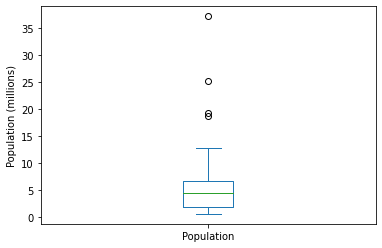

In [19]:
# 상자그림
# axes: 보통 plot(플롯은 일반적으로 둘 이상의 변수 간의 관계를 나타내는 그래프)으로 생각하는 하나의 그래프
ax = (state['Population']/1_000_000).plot.box()

ax.set_ylabel('Population (millions)') # y축 label

#### 상자그림 해석
- 주별 인구의 중간값(제2사분위수, $ Q_2 $): 약 500만(박스의 녹색 선)
- 사분위범위(IQR): 주 절반이 약 200만(제1사분위수, $ Q_1 $) ~ 약 700만(제3사분위수, $ Q_3 $) 사이임(박스의 하단 ~ 박스의 상단)
- 인구수가 높은 이상치가 존재함(상단에 동그라미들)
- 박스와 연결된 선(수염, whisker)의 최상단, 최하단: $ Q_3 $와 차이가 1.5IQR 이내인 값 중에서 최댓값, $ Q_1 $과 차이가 1.5IQR 이내인 값 중에서 최솟값
- $ Q_3 $보다 1.5IQR 이상 초과하는 값과 $ Q_1 $보다 1.5IQR 이상 미달하는 값은 점은 원이나 별표 등으로 따로 표시함(이상치, 특잇값)

### 1.5.2 도수분포표와 히스토그램

In [20]:
# 도수분포표
binnedPopulation = pd.cut(state['Population'], 10) # 10개의 동일한 크기의 구간으로 나눈 뒤, 각 구간마다 몇 개의 변숫값이 존재하는지
# binnedPopulation.value_counts()

In [21]:
binnedPopulation.name = 'binnedPopulation'
df = pd.concat([state, binnedPopulation], axis=1)
df = df.sort_values(by='Population')

groups = []
for group, subset in df.groupby(by='binnedPopulation'):
    groups.append({
        'BinRange': group,
        'Count': len(subset),
        'States': ','.join(subset.Abbreviation)
    })
print(pd.DataFrame(groups))

                   BinRange  Count  \
0    (526935.67, 4232659.0]     24   
1    (4232659.0, 7901692.0]     14   
2   (7901692.0, 11570725.0]      6   
3  (11570725.0, 15239758.0]      2   
4  (15239758.0, 18908791.0]      1   
5  (18908791.0, 22577824.0]      1   
6  (22577824.0, 26246857.0]      1   
7  (26246857.0, 29915890.0]      0   
8  (29915890.0, 33584923.0]      0   
9  (33584923.0, 37253956.0]      1   

                                              States  
0  WY,VT,ND,AK,SD,DE,MT,RI,NH,ME,HI,ID,NE,WV,NM,N...  
1          KY,LA,SC,AL,CO,MN,WI,MD,MO,TN,AZ,IN,MA,WA  
2                                  VA,NJ,NC,GA,MI,OH  
3                                              PA,IL  
4                                                 FL  
5                                                 NY  
6                                                 TX  
7                                                     
8                                                     
9                              

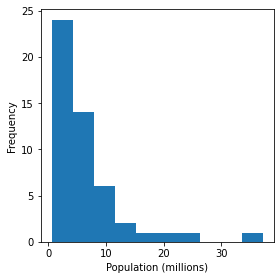

In [22]:
# 히스토그램
ax = (state['Population'] / 1_000_000).plot.hist(figsize=(4, 4))
ax.set_xlabel('Population (millions)')

plt.tight_layout()
plt.show()

#### 통계학에서 말하는 모멘트(적률)
- 일차 모멘트: 위치
- 이차 모멘트: 변이
- 삼차 모멘트: 왜도(skewness) -> 데이터가 큰 값이나 작은 값 쪽으로 얼마나 비스듬히 쏠려 있는지를 나타냄
- 사차 모멘트: 첨도(kurtosis) -> 데이터가 극단 값을 갖는 경향성을 나타냄

보통 이러한 값들은 직접 구하기보다는 시각화해서 확인함

### 1.5.4 밀도 그림과 추정

#### 커널 밀도 추정(kernel density estimation, KDE): 커널 함수를 이용한 밀도 추정 방법

#### 커널함수: 아래 3가지 조건을 모두 만족하는 함수
1. $ ∫^{\infty}_{-\infty}K(u)du = 1 $
2. $ K(-u) = K(u) $ for all values of u
3. Non-negative

#### 커널 밀도 추정: 관측된 데이터마다 해당 데이터를 중심으로 하는 커널 함수를 생성한 후 해당 커널 함수를 모두 더하고 데이터 개수로 나누면 KDE로 도출된 확률 밀도 함수를 구할 수 있음

### 예시)

|sample|1|2|3|4|5|6|
|------|-|-|-|-|-|-|
|value|-2.1|-1.3|-0.4|1.9|5.1|6.2|

1. 커널 함수를 하나 정하고
2. -2.1을 중심으로 커널 함수 하나 그리고
3. -1.3을 중심으로 커널 함수 또 하나 그리고
4. 6.2까지 다 그리고
5. 6개의 커널 함수들을 더한 후 6으로 나눔
6. 커널 밀도 추정으로 도출된 확률 밀도 함수 완성
- 어떠한 커널함수를 사용할지보다는 Bandwidth가 중요 -> Bandwidth에 따라 그래프가 얼마나 smooth할지가 정해지기 때문

Text(0.5, 0, 'Murder Rate (per 100,000)')

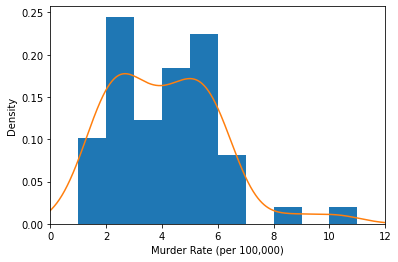

In [23]:
ax = state['Murder.Rate'].plot.hist(density=True, xlim=[0,12], bins=range(1,12))
state['Murder.Rate'].plot.density(ax=ax)
ax.set_xlabel('Murder Rate (per 100,000)')

# 밀도 그림

## 1.6 이진 데이터와 범주 데이터 탐색하기

#### 범주형 데이터에서는 간단한 비율이나 퍼센트를 이용해 데이터에 관해 이야기할 수 있음

- 최빈값(mode): 데이터에서 가장 자주 등장하는 범주 혹은 값
- 기댓값(expected value): 범주에 해당하는 어떤 수치가 있을 때, 범주의 출현 확률에 따른 평균
- 막대도표(bar chart): 각 범주의 빈도수 혹은 비율을 막대로 나타낸 그림
- 파이그림(pie chart): 각 범주의 빈도수 혹은 비율을 원의 부채꼴 모양으로 나타낸 그림

In [24]:
dfw = pd.read_csv('./data/dfw_airline.csv')

In [25]:
print(100 * dfw / dfw.values.sum()) # 퍼센트 비율

     Carrier        ATC   Weather  Security    Inbound
0  23.022989  30.400781  4.025214  0.122937  42.428079


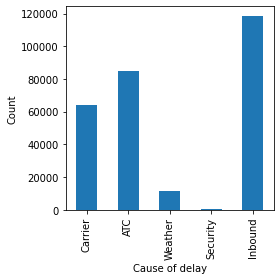

In [26]:
ax = dfw.transpose().plot.bar(figsize=(4, 4), legend=False) # transpose(): 행과 열 전환하기
ax.set_xlabel('Cause of delay')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()
# 막대도표

# 막대도표와 히스토그램의 차이점
# 막대도표는 자료의 범주별 빈도 그래프
# 히스토그램은 연속형 자료에 대한 그래프 -> 막대들은 서로 붙어있고 중간에 틈이 있으면 그 부분에 해당하는 값이 존재하지 않는다는 것

## 1.7 상관관계

- 상관계수(correlation coefficient): 수치적 변수들 간에 어떤 관계가 있는지를 나타내기 위해 사용되는 측정량(-1 ~ +1)
- 상관행렬(correlation matrix): 행과 열이 변수들을 의미하는 표 -> 각 셀은 행과 열에 해당하는 변수들 간의 상관관계를 의미
- 산점도(scatterplot): x축과 y축이 서로 다른 두 개의 변수를 나타내는 도표
$$ r = \frac{Σ^n_{i=1}(x_i - \bar{x})(y_i - \bar{y})}{(n-1)s_xs_y} $$

In [27]:
sp500_sym = pd.read_csv('./data/sp500_sectors.csv')
sp500_px = pd.read_csv('./data/sp500_data.csv', index_col=0)

In [28]:
telecomSymbols = sp500_sym[sp500_sym['sector'] == 'telecommunications_services']['symbol']

telecom = sp500_px.loc[sp500_px.index >= '2012-07-01', telecomSymbols]
telecom.corr()
print(telecom)

                   T       CTL       FTR        VZ      LVLT
2012-07-02  0.422496  0.140847  0.070879  0.554180 -0.519998
2012-07-03 -0.177448  0.066280  0.070879 -0.025976 -0.049999
2012-07-05 -0.160548 -0.132563  0.055128 -0.051956 -0.180000
2012-07-06  0.342205  0.132563  0.007875  0.140106 -0.359999
2012-07-09  0.136883  0.124279 -0.023626  0.253943  0.180000
...              ...       ...       ...       ...       ...
2015-06-25  0.049342 -1.600000 -0.040000 -0.187790 -0.330002
2015-06-26 -0.256586  0.039999 -0.070000  0.029650 -0.739998
2015-06-29 -0.098685 -0.559999 -0.060000 -0.504063 -1.360000
2015-06-30 -0.503298 -0.420000 -0.070000 -0.523829  0.199997
2015-07-01 -0.019737  0.080000 -0.050000  0.355811  0.139999

[754 rows x 5 columns]


In [29]:
etfs = sp500_px.loc[sp500_px.index > '2012-07-01', 
                    sp500_sym[sp500_sym['sector'] == 'etf']['symbol']]
print(etfs.head())

                 XLI       QQQ       SPY       DIA       GLD    VXX       USO  \
2012-07-02 -0.376098  0.096313  0.028223 -0.242796  0.419998 -10.40  0.000000   
2012-07-03  0.376099  0.481576  0.874936  0.728405  0.490006  -3.52  0.250000   
2012-07-05  0.150440  0.096313 -0.103487  0.149420  0.239991   6.56 -0.070000   
2012-07-06 -0.141040 -0.491201  0.018819 -0.205449 -0.519989  -8.80 -0.180000   
2012-07-09  0.244465 -0.048160 -0.056445 -0.168094  0.429992  -0.48  0.459999   

                 IWM       XLE       XLY       XLU       XLB       XTL  \
2012-07-02  0.534641  0.028186  0.095759  0.098311 -0.093713  0.019076   
2012-07-03  0.926067  0.995942  0.000000 -0.044686  0.337373  0.000000   
2012-07-05 -0.171848 -0.460387  0.306431 -0.151938  0.103086  0.019072   
2012-07-06 -0.229128  0.206706  0.153214  0.080437  0.018744 -0.429213   
2012-07-09 -0.190939 -0.234892 -0.201098 -0.035751 -0.168687  0.000000   

                 XLV       XLP       XLF       XLK  
2012-07-02 -0.0

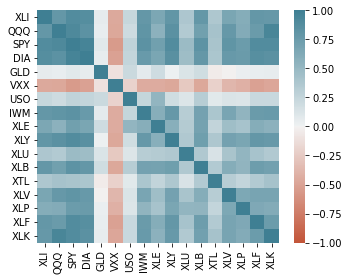

In [30]:
fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.heatmap(etfs.corr(), vmin=-1, vmax=1, 
                 cmap=sns.diverging_palette(20, 220, as_cmap=True),
                 ax=ax)

plt.tight_layout()
plt.show()

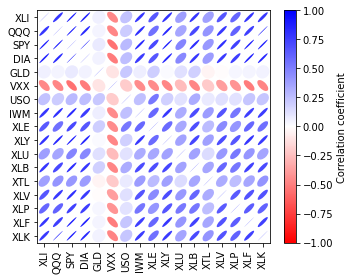

In [31]:
from matplotlib.collections import EllipseCollection
from matplotlib.colors import Normalize

def plot_corr_ellipses(data, figsize=None, **kwargs):
    ''' https://stackoverflow.com/a/34558488 '''
    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')
    fig, ax = plt.subplots(1, 1, figsize=figsize, subplot_kw={'aspect':'equal'})
    ax.set_xlim(-0.5, M.shape[1] - 0.5)
    ax.set_ylim(-0.5, M.shape[0] - 0.5)
    ax.invert_yaxis()

    # xy locations of each ellipse center
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T

    # set the relative sizes of the major/minor axes according to the strength of
    # the positive/negative correlation
    w = np.ones_like(M).ravel() + 0.01
    h = 1 - np.abs(M).ravel() - 0.01
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           norm=Normalize(vmin=-1, vmax=1),
                           transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(ec)

    # if data is a DataFrame, use the row/column names as tick labels
    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index)

    return ec, ax

m, ax = plot_corr_ellipses(etfs.corr(), figsize=(5, 4), cmap='bwr_r')
cb = fig.colorbar(m, ax=ax)
cb.set_label('Correlation coefficient')

plt.tight_layout()
plt.show()

### 1.7.1 산점도

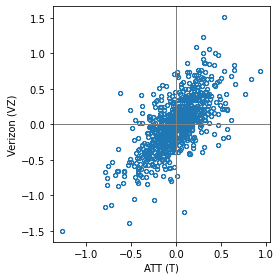

In [32]:
ax = telecom.plot.scatter(x='T', y='VZ', figsize=(4, 4), marker='$\u25EF$')
ax.set_xlabel('ATT (T)')
ax.set_ylabel('Verizon (VZ)')
ax.axhline(0, color='grey', lw=1)
ax.axvline(0, color='grey', lw=1)

plt.tight_layout()
plt.show()

## 1.8 두 개 이상의 변수 탐색하기

- 평균과 분산과 같은 추정값들은 한 번에 하나의 변수를 다룸 -> 일변량분석(univariate analysis)
- 상관분석은 두 변수를 비교 -> 이변량분석(bivariate analysis)
- 셋 이상의 변수를 다루는 법 -> 다변량분석(multivariate analysis)

---
- 분할표(contingency table): 두 가지 이상의 범주형 변수의 빈도수를 기록한 표
- 육각형 구간(hexagonal binning): 두 변수를 육각형 모양의 구간으로 나눈 그림
- 등고 도표(contour plot): 지도상에 같은 높이의 지점을 등고선으로 나타내는 것처럼 두 변수의 밀도를 등고선으로 표시한 도표
- 바이올린 도표(violin plot): 상자그림과 비슷하지만 밀도추정을 함께 보여줌

In [33]:
# 워싱턴주 킹 카운티의 주택 시설에 대한 과세 평가 금액 정보를 담고 있는 데이터 집합
# 데이터의 주요 부분에 집중하기 위해 아주 비싸거나 너무 작거나 너무 큰 주택들은 subset 함수를 이용해 제거
kc_tax = pd.read_csv('./data/kc_tax.csv')
kc_tax0 = kc_tax.loc[(kc_tax.TaxAssessedValue < 750000) & 
                     (kc_tax.SqFtTotLiving > 100) &
                     (kc_tax.SqFtTotLiving < 3500), :]
print(kc_tax0.shape)

(432693, 3)


In [34]:
kc_tax0.head()

,TaxAssessedValue,SqFtTotLiving,ZipCode
1,206000.0,1870,98002.0
2,303000.0,1530,98166.0
3,361000.0,2000,98108.0
4,459000.0,3150,98108.0
5,223000.0,1570,98032.0


### 1.8.1 육각형 구간과 등고선(수치형 변수 - 수치형 변수를 시각화)

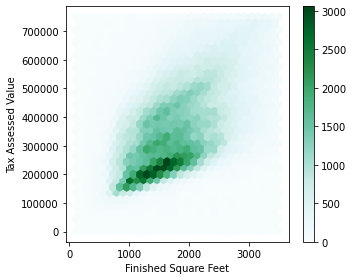

In [35]:
ax = kc_tax0.plot.hexbin(x='SqFtTotLiving', y='TaxAssessedValue',
                         gridsize=30, sharex=False, figsize=(5, 4))
ax.set_xlabel('Finished Square Feet')
ax.set_ylabel('Tax Assessed Value')

plt.tight_layout()
plt.show()

# 집의 크기와 과세 평가 금액이 양의 상관관계를 갖는 것을 알 수 있음
# 명도 - 기록값의 개수

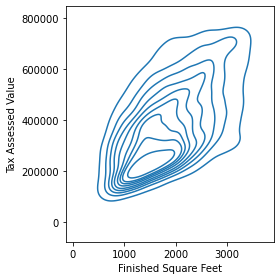

In [36]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.kdeplot(data=kc_tax0.sample(10000), x='SqFtTotLiving', y='TaxAssessedValue', ax=ax)
ax.set_xlabel('Finished Square Feet')
ax.set_ylabel('Tax Assessed Value')

plt.tight_layout()
plt.show()

# 등고선 위의 점들은 밀도가 같음
# 꼭대기로 갈수록 밀도가 높아짐

### 1.8.2 범주형 변수 - 범주형 변수

In [37]:
lc_loans = pd.read_csv('./data/lc_loans.csv')

In [38]:
crosstab = lc_loans.pivot_table(index='grade', columns='status', 
                                aggfunc=lambda x: len(x), margins=True)
print(crosstab)

# 개인대출 등급과 대출 결과를 나타내는 분할표
# 등급(grade), Charged Off(대출 잔여금 회수 불능), Current(진행 중), Fully Paid(전액 상환), Late(연체)

status  Charged Off  Current  Fully Paid  Late     All
grade                                                 
A              1562    50051       20408   469   72490
B              5302    93852       31160  2056  132370
C              6023    88928       23147  2777  120875
D              5007    53281       13681  2308   74277
E              2842    24639        5949  1374   34804
F              1526     8444        2328   606   12904
G               409     1990         643   199    3241
All           22671   321185       97316  9789  450961


In [39]:
df = crosstab.copy().loc['A':'G',:]
df.loc[:, 'Charged Off':'Late'] = df.loc[:, 'Charged Off':'Late'].div(df['All'], axis=0)
df['All'] = df['All'] / sum(df['All'])
perc_crosstab = df
print(perc_crosstab)

status  Charged Off   Current  Fully Paid      Late       All
grade                                                        
A          0.021548  0.690454    0.281528  0.006470  0.160746
B          0.040054  0.709013    0.235401  0.015532  0.293529
C          0.049828  0.735702    0.191495  0.022974  0.268039
D          0.067410  0.717328    0.184189  0.031073  0.164708
E          0.081657  0.707936    0.170929  0.039478  0.077177
F          0.118258  0.654371    0.180409  0.046962  0.028614
G          0.126196  0.614008    0.198396  0.061401  0.007187


### 1.8.3 범주형 변수 - 수치형 변수

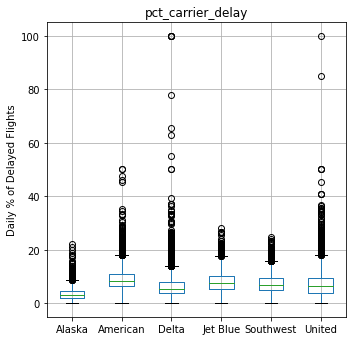

In [40]:
airline_stats = pd.read_csv('./data/airline_stats.csv')
airline_stats.head()
ax = airline_stats.boxplot(by='airline', column='pct_carrier_delay',
                           figsize=(5, 5))
ax.set_xlabel('')
ax.set_ylabel('Daily % of Delayed Flights')
plt.suptitle('')

plt.tight_layout()
plt.show()

# 항공사별 비행 지연 정도를 비교하는 상자그림

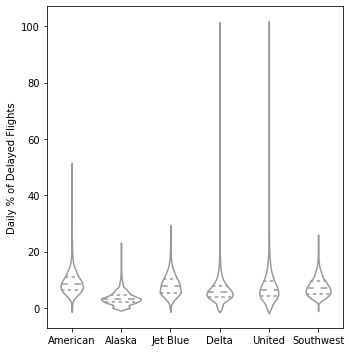

In [41]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.violinplot(data=airline_stats, x='airline', y='pct_carrier_delay',
               ax=ax, inner='quartile', color='white')
ax.set_xlabel('')
ax.set_ylabel('Daily % of Delayed Flights')

plt.tight_layout()
plt.show()

# 밀도추정 결과를 동시에 시각화한 바이올린 도표
# 상자그림에서는 보기 힘든 데이터의 분포를 볼 수 있음
# 특잇값들은 상자그림이 더 명확함

### 1.8.4 다변수 시각화하기

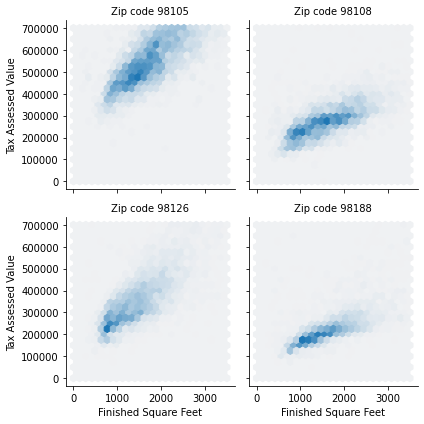

In [42]:
# 조건화를 통해 두 변수 비교용 도표를 더 여러 변수를 비교하는 용도로 확장하여 활용할 수 잇음
# 아래는 우편번호를 조건화 변수로 사용

zip_codes = [98188, 98105, 98108, 98126]
kc_tax_zip = kc_tax0.loc[kc_tax0.ZipCode.isin(zip_codes),:]
kc_tax_zip

def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=25, cmap=cmap, **kwargs)

g = sns.FacetGrid(kc_tax_zip, col='ZipCode', col_wrap=2)
g.map(hexbin, 'SqFtTotLiving', 'TaxAssessedValue', 
      extent=[0, 3500, 0, 700000])
g.set_axis_labels('Finished Square Feet', 'Tax Assessed Value')
g.set_titles('Zip code {col_name:.0f}')

plt.tight_layout()
plt.show()